In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [7]:
def load_time_curve_cntRFF(time_stop, thds, num_thds, snr=None, th_acc=None, show_acc_range=False, show_out60sec=False, pretrained=False):
    print("\n-----------Loading SNR{}dB-------------".format(snr))

    if pretrained:
        # Transfer learning time_curve results
        if snr==35 or snr==25 or snr==30:
            path = "G:/My Drive/CMU/Research/attacker/code/ML/checkpoint2/gan/gan_vae_PA_transfer_fixed/snr"+str(snr)+"/remote/time_curve_retrain_with_seeds/"
        elif snr==5 or snr==15 or snr == 10 or snr==20:
            path = "G:/My Drive/CMU/Research/attacker/code/ML/checkpoint2/gan/gan_vae_PA_transfer_fixed/snr"+str(snr)+"/remote/time_curve/"
    else:
        ## New training results
        if snr == 35 or snr == 30:
            path = "G:/My Drive/CMU/Research/attacker/code/ML/checkpoint2/gan/gan_vae_PA_fixed/snr"+str(snr)+"/time_curve_merge/"
        else:
            path = "G:/My Drive/CMU/Research/attacker/code/ML/checkpoint2/gan/gan_vae_PA_fixed/snr"+str(snr)+"/seed0/time_curve/"
    
    paths = [path]
    files = [os.listdir(p) for p in paths]
    for i in range(len(files)):
        print("files{} len:{}".format(i, len(files[i])))

    cnt=0
    acc_range=[(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.01)]
    cnt_range=[[] for _ in range(len(acc_range))]

    timer_curve_all={}
    for idx in range(len(paths)):
        path = paths[idx]
        filelist = files[idx]
        for file in filelist:
            file_name_len = 3 if pretrained else 4
            if file.split('.')[-1] == 'npy' and len(file.split("_"))==file_name_len:
                rfflabel = int(file.split('_')[-1].split('.')[0])
                dict_load = np.load(path+file, allow_pickle=True).item()
                val_acc = dict_load[rfflabel][-1][-1]
                if rfflabel not in timer_curve_all.keys():
                    for i in range(len(acc_range)):
                        (x,y) = acc_range[i]
                        if x<=val_acc<y :
                            cnt_range[i].append(rfflabel)
                            cnt+=1
                    if th_acc[0]<=val_acc<th_acc[1]: 
                        timer_curve_all.update(dict_load)
                else:
                    max_time_pre = timer_curve_all[rfflabel][-2][-1]
                    val_acc = dict_load[rfflabel][-1][-1]
                    max_time = dict_load[rfflabel][-2][-1]
                    if max_time<=max_time_pre:
                        timer_curve_all.update(dict_load)
                        for i in range(len(acc_range)):
                            if rfflabel in cnt_range[i]:
                                cnt_range[i].remove(rfflabel)
                        for i in range(len(acc_range)):
                            (x,y) = acc_range[i]
                            if x<=val_acc<y:
                                cnt_range[i].append(rfflabel)
                                
    print("#cnt_range:", cnt)
    if show_acc_range:
        for i in range(len(acc_range)):
            print("acc_range:{}, cnt:{}".format(acc_range[i], len(cnt_range[i])))

    rfflabels = list(timer_curve_all.keys())
    # print("#{} rfflabels in time_curve_all: {}".format(len(rfflabels), rfflabels))
    if len(rfflabels)<219:
        print("#miss rfflabel:", 219-len(rfflabels), end=' ')
        for i in range(1, 220):
            if i not in rfflabels:
                print(i, end=', ')
    else:
        print("No missing rffs")
    
    in_time_stop=[]
    out_time_stop=[]
    n_epochs=[]
    best_val_acc = np.zeros(len(timer_curve_all.keys()))
    best_val_acc_intimestop = np.zeros(len(timer_curve_all.keys()))

    cnt_thds=np.zeros(len(thds))
    cnt_thds_intimestop=np.zeros(len(thds))

    acc_num_thds = np.zeros(len(num_thds))
    acc_num_thds_intimestop = np.zeros(len(num_thds))

    for rff in timer_curve_all.keys():
        test_time = timer_curve_all[rff][-2][-1]
        val_acc = timer_curve_all[rff][-1][-1]
        best_val_acc[rff-1] = np.max(timer_curve_all[rff][-1])
        for thdi in range(len(thds)):
            thd = thds[thdi]
            if best_val_acc[rff-1]>=thd:
                cnt_thds[thdi]+=1
        n_epochs.append(len(timer_curve_all[rff][0]))
        if test_time<=time_stop:# and val_acc>=0.9:
            in_time_stop.append(rff)
        else:
            out_time_stop.append(rff)

        train_time_step, train_time, train_acc_fake_curve, test_time_step, test_time, val_acc_fake_curve = timer_curve_all[rff]

        for i in range(len(test_time)):
            if 0<=time_stop-train_time[i]: # <0.15 when testing with tranfer learning results
                time_stop_train_i=i
            if 0<=time_stop-test_time[i]:
                time_stop_test_i=i
        best_val_acc_intimestop[rff-1] = np.max(timer_curve_all[rff][-1][:time_stop_test_i])
        for thdi in range(len(thds)):
            thd = thds[thdi]
            if best_val_acc_intimestop[rff-1]>=thd:
                cnt_thds_intimestop[thdi]+=1

    best_val_acc_sorted = np.flip(np.sort(best_val_acc))
    best_val_acc_sorted_intimestop = np.flip(np.sort(best_val_acc_intimestop))
    print("SNR:{}".format(snr), end=", ")
    
    for thdi in range(len(thds)):
        thd = thds[thdi]
        print("({}, {})".format(thd, cnt_thds[thdi]), end=", ") if thdi<len(thds)-1 else print("({}, {})".format(thd, cnt_thds[thdi]))
    
    for i in range(len(num_thds)):
        num_thd = num_thds[i]
        acc_num_thds[i] = np.mean(best_val_acc_sorted[:num_thd])
        print("({}, {})".format(num_thd, acc_num_thds[i]), end=", ") if i<len(num_thds)-1 else print("({}, {})".format(num_thd, acc_num_thds[i]))

    for thdi in range(len(thds)):
        thd = thds[thdi]
        print("({}, {})".format(thd, cnt_thds_intimestop[thdi]), end=", ") if thdi<len(thds)-1 else print("({}, {})".format(thd, cnt_thds_intimestop[thdi]))
    
    for i in range(len(num_thds)):
        num_thd = num_thds[i]
        acc_num_thds_intimestop[i] = np.mean(best_val_acc_sorted_intimestop[:num_thd])
        print("({}, {})".format(num_thd, acc_num_thds_intimestop[i]), end=", ") if i<len(num_thds)-1 else print("({}, {})".format(num_thd, acc_num_thds_intimestop[i]))

    return timer_curve_all, cnt_thds, acc_num_thds, cnt_thds_intimestop, acc_num_thds_intimestop


-----------Loading SNR30dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:30, (0.9, 219.0), (0.91, 213.0), (0.92, 208.0), (0.93, 188.0), (0.94, 176.0), (0.95, 132.0), (0.96, 102.0), (0.97, 63.0), (0.98, 42.0), (0.99, 14.0)
(100, 0.97609375), (150, 0.9683333333333334), (180, 0.9639539930555555), (200, 0.96056640625), (210, 0.958686755952381), (220, 0.9521661931818182)
(0.9, 175.0), (0.91, 162.0), (0.92, 139.0), (0.93, 115.0), (0.94, 89.0), (0.95, 61.0), (0.96, 46.0), (0.97, 20.0), (0.98, 9.0), (0.99, 3.0)
(100, 0.9577734375), (150, 0.9470833333333334), (180, 0.940234375), (200, 0.93537109375), (210, 0.9324032738095238), (220, 0.9082208806818182)

-----------Loading SNR30dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:30, (0.9, 219.0), (0.91, 213.0), (0.92, 208.0), (0.93, 188.0), (0.94, 176.0), (0.95, 132.0), (0.96, 102.0), (0.97, 63.0), (0.98, 42.0), (0.99, 14.0)
(100, 0.97609375), (150, 0.9683333333333334), (180, 0.9639539930555555), (200, 0.96056640625), (210, 0.958686755952381), (220, 0.9521661931818182)
(0.9, 176.0), (0.91, 163.0), (0.92, 140.0), (0.93, 115.0), (0.94, 89.0), (0.95, 61.0), (0.96, 46.0), (0.97, 20.0), (0.98, 9.0), (0.99, 3.0)
(100, 0.9577734375), (150, 0.9471875), (180, 0.9404079861111111), (200, 0.935703125), (210, 0.9328683035714286), (220, 0.9151100852272728)

-----------Loading SNR30dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:30, (0.9, 219.0), (0.91, 213.0), (0.92, 208.0), (0.93, 188.0), (0.94, 176.0), (0.95, 132.0), (0.96, 102.0), (0.97, 63.0), (0.98, 42.0), (0.99, 14.0)
(100, 0.97609375), (150, 0.9683333333333334), (180, 0.9639539930555555), (200, 0.96056640625), (210, 0.958686755952381), (220, 0.9521661931818182)
(0.9, 177.0), (0.91, 164.0), (0.92, 141.0), (0.93, 116.0), (0.94, 90.0), (0.95, 62.0), (0.96, 47.0), (0.97, 20.0), (0.98, 9.0), (0.99, 3.0)
(100, 0.9580078125), (150, 0.9475), (180, 0.9407552083333334), (200, 0.93607421875), (210, 0.933296130952381), (220, 0.9215376420454545)

-----------Loading SNR20dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:20, (0.9, 216.0), (0.91, 214.0), (0.92, 206.0), (0.93, 187.0), (0.94, 167.0), (0.95, 132.0), (0.96, 110.0), (0.97, 77.0), (0.98, 50.0), (0.99, 21.0)
(100, 0.979921875), (150, 0.9711458333333334), (180, 0.9657986111111111), (200, 0.96216796875), (210, 0.9601748511904762), (220, 0.9416370738636364)
(0.9, 188.0), (0.91, 173.0), (0.92, 152.0), (0.93, 123.0), (0.94, 99.0), (0.95, 65.0), (0.96, 51.0), (0.97, 33.0), (0.98, 21.0), (0.99, 9.0)
(100, 0.96265625), (150, 0.9516666666666667), (180, 0.9452256944444445), (200, 0.94060546875), (210, 0.9245349702380953), (220, 0.8830788352272727)

-----------Loading SNR20dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:20, (0.9, 216.0), (0.91, 214.0), (0.92, 206.0), (0.93, 187.0), (0.94, 167.0), (0.95, 132.0), (0.96, 110.0), (0.97, 77.0), (0.98, 50.0), (0.99, 21.0)
(100, 0.979921875), (150, 0.9711458333333334), (180, 0.9657986111111111), (200, 0.96216796875), (210, 0.9601748511904762), (220, 0.9416370738636364)
(0.9, 194.0), (0.91, 179.0), (0.92, 158.0), (0.93, 128.0), (0.94, 103.0), (0.95, 69.0), (0.96, 54.0), (0.97, 36.0), (0.98, 22.0), (0.99, 10.0)
(100, 0.964140625), (150, 0.95328125), (180, 0.9470920138888889), (200, 0.9426171875), (210, 0.9396205357142857), (220, 0.9012784090909091)

-----------Loading SNR20dB-------------
files0 len:221


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:20, (0.9, 216.0), (0.91, 214.0), (0.92, 206.0), (0.93, 187.0), (0.94, 167.0), (0.95, 132.0), (0.96, 110.0), (0.97, 77.0), (0.98, 50.0), (0.99, 21.0)
(100, 0.979921875), (150, 0.9711458333333334), (180, 0.9657986111111111), (200, 0.96216796875), (210, 0.9601748511904762), (220, 0.9416370738636364)
(0.9, 198.0), (0.91, 183.0), (0.92, 161.0), (0.93, 131.0), (0.94, 106.0), (0.95, 72.0), (0.96, 57.0), (0.97, 38.0), (0.98, 23.0), (0.99, 11.0)
(100, 0.965234375), (150, 0.9544010416666666), (180, 0.9482638888888889), (200, 0.94388671875), (210, 0.9416294642857143), (220, 0.9152166193181818)

-----------Loading SNR10dB-------------
files0 len:220


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:10, (0.9, 217.0), (0.91, 217.0), (0.92, 207.0), (0.93, 184.0), (0.94, 168.0), (0.95, 142.0), (0.96, 111.0), (0.97, 75.0), (0.98, 49.0), (0.99, 20.0)
(100, 0.9791015625), (150, 0.9710677083333333), (180, 0.9660590277777777), (200, 0.96244140625), (210, 0.9605282738095238), (220, 0.9461647727272727)
(0.9, 178.0), (0.91, 169.0), (0.92, 141.0), (0.93, 109.0), (0.94, 91.0), (0.95, 64.0), (0.96, 39.0), (0.97, 21.0), (0.98, 15.0), (0.99, 5.0)
(100, 0.9585546875), (150, 0.9476041666666667), (180, 0.9413411458333333), (200, 0.93556640625), (210, 0.9152715773809523), (220, 0.8739169034090909)

-----------Loading SNR10dB-------------
files0 len:220


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:10, (0.9, 217.0), (0.91, 217.0), (0.92, 207.0), (0.93, 184.0), (0.94, 168.0), (0.95, 142.0), (0.96, 111.0), (0.97, 75.0), (0.98, 49.0), (0.99, 20.0)
(100, 0.9791015625), (150, 0.9710677083333333), (180, 0.9660590277777777), (200, 0.96244140625), (210, 0.9605282738095238), (220, 0.9461647727272727)
(0.9, 183.0), (0.91, 174.0), (0.92, 146.0), (0.93, 113.0), (0.94, 94.0), (0.95, 67.0), (0.96, 41.0), (0.97, 23.0), (0.98, 15.0), (0.99, 5.0)
(100, 0.959453125), (150, 0.9487760416666666), (180, 0.9427734375), (200, 0.93763671875), (210, 0.9335379464285715), (220, 0.8936434659090909)

-----------Loading SNR10dB-------------
files0 len:220


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#cnt_range: 220
No missing rffs
SNR:10, (0.9, 217.0), (0.91, 217.0), (0.92, 207.0), (0.93, 184.0), (0.94, 168.0), (0.95, 142.0), (0.96, 111.0), (0.97, 75.0), (0.98, 49.0), (0.99, 20.0)
(100, 0.9791015625), (150, 0.9710677083333333), (180, 0.9660590277777777), (200, 0.96244140625), (210, 0.9605282738095238), (220, 0.9461647727272727)
(0.9, 184.0), (0.91, 175.0), (0.92, 147.0), (0.93, 114.0), (0.94, 94.0), (0.95, 67.0), (0.96, 41.0), (0.97, 23.0), (0.98, 15.0), (0.99, 5.0)
(100, 0.959453125), (150, 0.94890625), (180, 0.9429470486111111), (200, 0.9379296875), (210, 0.9341517857142857), (220, 0.8979048295454546)


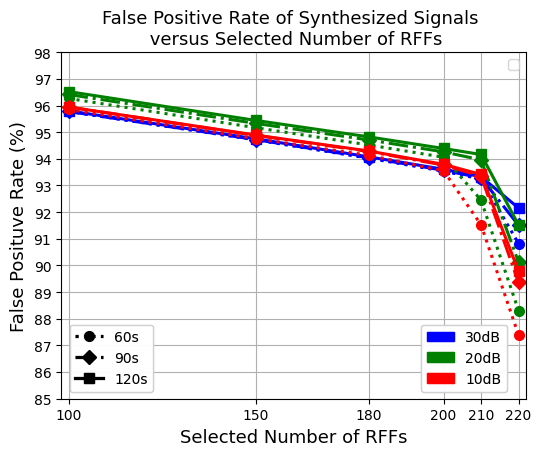

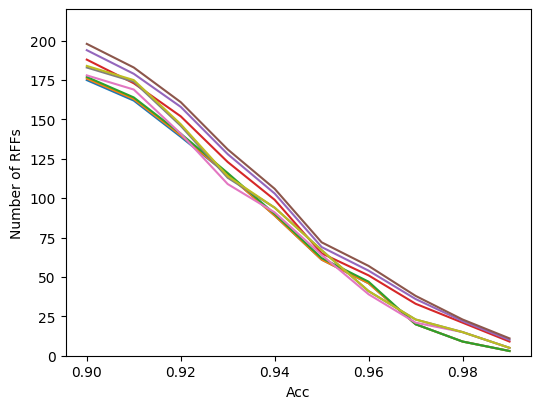

In [25]:
import matplotlib.patches as mpatches

pretrained=False
SNRs_all=[ 35, 30, 25, 20, 15, 10, 5]
SNRs_30 =[30, 20, 10]
SNRs_25=[ 25, 15, 5]
SNRs = SNRs_30
ths_acc={5:(0, 1.01), 10:(0, 1.01), 15:(0, 1.01), 20:(0., 1.01), 25:(0, 1.01), 30:(0, 1.01), 35:(0, 1.01)}
thds=[0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99] 
num_thds= [100, 150, 180, 200, 210, 219] if pretrained else [100, 150, 180, 200, 210, 220]
time_stops = [60, 90, 120]

fig1, ax1 = plt.subplots(figsize=(6, 4.5))
fig2, ax2 = plt.subplots(figsize=(6, 4.5))
colors=list(mcolors.BASE_COLORS)[:len(SNRs)] # snr
markers = ['o', 'D', 's'] # time_stop
linestyles=[':', '-.', '-']

for snri in range(len(SNRs)):
    SNR = SNRs[snri]
    for time_stopi in range(len(time_stops)):
        time_stop = time_stops[time_stopi]
        timer_curve_all, cnt_thds, acc_num_thds, cnt_thds_intimestop, acc_num_thds_intimestop = load_time_curve_cntRFF(time_stop=time_stop, 
                                                                                                                    thds=thds, 
                                                                                                                    num_thds=num_thds, 
                                                                                                                    snr=SNR, 
                                                                                                                    th_acc=ths_acc[SNR], 
                                                                                                                    pretrained=pretrained)
        
        ax1.plot(num_thds, 100*acc_num_thds_intimestop, linestyle=linestyles[time_stopi], marker=markers[time_stopi], color=colors[snri], linewidth=2.2, markersize=7,)# label="{}dB at {}s".format(SNR, time_stop))
        # ax1.hlines(y=acc_num_thds_intimestop[-1], xmin=98, xmax=219, linewidth=2.2, linestyle=linestyles[time_stopi], color=colors[snri], linestyles=':')
        ax1.set_xlabel("Selected Number of RFFs", fontsize=13)
        ax1.set_ylabel("False Posituve Rate (%)", fontsize=13)
        if pretrained:
            title = "False Positive Rate of Synthesized Signals \n versus Selected Number of RFFs - Transfer Learning"
        else:
            title = "False Positive Rate of Synthesized Signals \n versus Selected Number of RFFs"
        ax1.set_title(title, fontsize=13)
        ax1.set_xlim([98, 222])
        ax1.set_ylim([85, 97.5])
        ax1.set_yticks([85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])
        ax1.set_xticks(num_thds)
        ax1.grid()
        ax1.legend()
        ax2.plot(thds, cnt_thds_intimestop, label="{}dB".format(SNR))
        ax2.set_xlabel("Acc")
        ax2.set_ylabel("Number of RFFs")
        ax2.set_ylim([0, 220])

patches1 = [mpatches.Patch(color=colors[i], label='{}dB'.format(SNRs[i])) for i in range(len(SNRs))]
patches2 = [plt.plot([],[], color='black', marker=markers[i], ls=linestyles[i], linewidth=2.3, markersize=7, mec=None, label="{}s".format(time_stops[i]))[0]  for i in range(len(time_stops))]

legend1=fig1.legend(handles=patches1, bbox_to_anchor=(0.88, 0.29))
legend2=fig1.legend(handles=patches2, bbox_to_anchor=(0.29, 0.29))
ax1.add_artist(legend1)
ax1.add_artist(legend2)

if pretrained:       
    save_fig = "./checkpoint2/results/figure/pa_fpr_numrffs_intimestops_transfer_"+str(SNRs[0])+"dB_newlegend.svg"
else:
    save_fig = "./checkpoint2/results/figure/pa_fpr_numrffs_intimestops_notransfer_"+str(SNRs[0])+"dB_newlegend.svg"
fig1.savefig(save_fig)
plt.show()

In [18]:
print(acc_num_thds_intimestop)

[0.95800781 0.9475     0.94075521 0.93607422 0.93329613 0.92153764]
